钩子编程（hooking），也称作“挂钩”，是计算机程序设计术语，指通过拦截软件模块间的函数调用、消息传递、事件传递来修改或扩展操作系统、应用程序或其他软件组件的行为的各种技术。处理被拦截的函数调用、事件、消息的代码，被称为钩子（hook）

Hook 是 PyTorch 中一个十分有用的特性。利用它，我们可以不必改变网络输入输出的结构，方便地获取、改变网络中间层变量的值和梯度。这个功能被广泛用于可视化神经网络中间层的 feature、gradient，从而诊断神经网络中可能出现的问题，分析网络有效性

1. Hook for Tensors ：针对 Tensor 的 hook
2. Hook for Modules：针对例如 nn.Conv2dnn.Linear等网络模块的 hook
3. Guided Backpropagation：利用 Hook 实现的一段神经网络可视化代码

Hook for Tensors

In [2]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x+y
# z.retain_grad()

o = w.matmul(z)
o.backward()
# o.retain_grad()

print('x.requires_grad:', x.requires_grad) # True
print('y.requires_grad:', y.requires_grad) # True
print('z.requires_grad:', z.requires_grad) # True
print('w.requires_grad:', w.requires_grad) # True
print('o.requires_grad:', o.requires_grad) # True


print('x.grad:', x.grad) # tensor([1., 2., 3., 4.])
print('y.grad:', y.grad) # tensor([1., 2., 3., 4.])
print('w.grad:', w.grad) # tensor([ 4.,  6.,  8., 10.])
print('z.grad:', z.grad) # None
print('o.grad:', o.grad) # None

x.requires_grad: True
y.requires_grad: True
z.requires_grad: True
w.requires_grad: True
o.requires_grad: True
x.grad: tensor([1., 2., 3., 4.])
y.grad: tensor([1., 2., 3., 4.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None
o.grad: None


对于中间变量z，hook 的使用方式为：z.register_hook(hook_fn)，其中 hook_fn为一个用户自定义的函数

    hook_fn(grad) -> Tensor or None

In [4]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x+y

# ===================
def hook_fn(grad):
    print(grad)

z.register_hook(hook_fn)
# ===================

o = w.matmul(z)

print('=====Start backprop=====')
o.backward()
print('=====End backprop=====')

print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('w.grad:', w.grad)
print('z.grad:', z.grad)

=====Start backprop=====
tensor([1., 2., 3., 4.])
=====End backprop=====
x.grad: tensor([1., 2., 3., 4.])
y.grad: tensor([1., 2., 3., 4.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None


In [5]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y


# ===================
def hook_fn(grad):
    g = 2 * grad
    print(g)
    return g


z.register_hook(hook_fn)
# ===================

o = w.matmul(z)

print('=====Start backprop=====')
o.backward()
print('=====End backprop=====')

print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('w.grad:', w.grad)
print('z.grad:', z.grad)

=====Start backprop=====
tensor([2., 4., 6., 8.])
=====End backprop=====
x.grad: tensor([2., 4., 6., 8.])
y.grad: tensor([2., 4., 6., 8.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None


In [6]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y

# ===================
z.register_hook(lambda x: 2*x)
z.register_hook(lambda x: print(x))
# ===================

o = w.matmul(z)

print('=====Start backprop=====')
o.backward()
print('=====End backprop=====')

print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('w.grad:', w.grad)
print('z.grad:', z.grad)

=====Start backprop=====
tensor([2., 4., 6., 8.])
=====End backprop=====
x.grad: tensor([2., 4., 6., 8.])
y.grad: tensor([2., 4., 6., 8.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None


Hook for Modules

网络模块 module 不像上一节中的 Tensor，拥有显式的变量名可以直接访问，而是被封装在神经网络中间。我们通常只能获得网络整体的输入和输出，对于夹在网络中间的模块，我们不但很难得知它输入/输出的梯度，甚至连它输入输出的数值都无法获得。除非设计网络时，在 forward 函数的返回值中包含中间 module 的输出，或者用很麻烦的办法，把网络按照 module 的名称拆分再组合，让中间层提取的 feature 暴露出来。

为了解决这个麻烦，PyTorch 设计了两种 hook：register_forward_hook 和 register_backward_hook，分别用来获取正/反向传播时，中间层模块输入和输出的 feature/gradient，大大降低了获取模型内部信息流的难度

register forward hook

register_forward_hook的作用是获取前向传播过程中，各个网络模块的输入和输出。对于模块 module，其使用方式为：module.register_forward_hook(hook_fn) 。其中 hook_fn的签名为：

    hook_fn(module, input, output) -> None
    
它的输入变量分别为：模块，模块的输入，模块的输出，和对 Tensor 的 hook 不同，forward hook 不返回任何值，也就是说不能用它来修改输入或者输出的值（注意：从 pytorch 1.2.0 开始，forward hook 也有返回值了，可以修改网络模块的输出），但借助这个 hook，我们可以方便地用预训练的神经网络提取特征，而不用改变预训练网络的结构

In [7]:
import torch
from torch import nn

# 首先我们定义一个模型
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.initialize()
    
    # 为了方便验证，我们将指定特殊的weight和bias
    def initialize(self):
        with torch.no_grad():
            self.fc1.weight = torch.nn.Parameter(
                torch.Tensor([[1., 2., 3.],
                              [-4., -5., -6.],
                              [7., 8., 9.],
                              [-10., -11., -12.]]))

            self.fc1.bias = torch.nn.Parameter(torch.Tensor([1.0, 2.0, 3.0, 4.0]))
            self.fc2.weight = torch.nn.Parameter(torch.Tensor([[1.0, 2.0, 3.0, 4.0]]))
            self.fc2.bias = torch.nn.Parameter(torch.Tensor([1.0]))

    def forward(self, x):
        o = self.fc1(x)
        o = self.relu1(o)
        o = self.fc2(o)
        return o

# 全局变量，用于存储中间层的 feature
total_feat_out = []
total_feat_in = []

# 定义 forward hook function
def hook_fn_forward(module, input, output):
    print(module) # 用于区分模块
    print('input', input) # 首先打印出来
    print('output', output)
    total_feat_out.append(output) # 然后分别存入全局 list 中
    total_feat_in.append(input)


model = Model()

modules = model.named_children() # 
for name, module in modules:
    module.register_forward_hook(hook_fn_forward)

# 注意下面代码中 x 的维度，对于linear module，输入一定是大于等于二维的
# （第一维是 batch size）。在 forward hook 中看不出来，但是 backward hook 中，
# 得到的梯度完全不对。

x = torch.Tensor([[1.0, 1.0, 1.0]]).requires_grad_() 
o = model(x)
o.backward()

print('==========Saved inputs and outputs==========')
for idx in range(len(total_feat_in)):
    print('input: ', total_feat_in[idx])
    print('output: ', total_feat_out[idx])

Linear(in_features=3, out_features=4, bias=True)
input (tensor([[1., 1., 1.]], requires_grad=True),)
output tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward>)
ReLU()
input (tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward>),)
output tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ThresholdBackward0>)
Linear(in_features=4, out_features=1, bias=True)
input (tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ThresholdBackward0>),)
output tensor([[89.]], grad_fn=<AddmmBackward>)
==========Saved inputs and outputs==========
input:  (tensor([[1., 1., 1.]], requires_grad=True),)
output:  tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward>)
input:  (tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward>),)
output:  tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ThresholdBackward0>)
input:  (tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ThresholdBackward0>),)
output:  tensor([[89.]], grad_fn=<AddmmBackward>)


register backward hook

和 register_forward_hook相似，register_backward_hook 的作用是获取神经网络反向传播过程中，各个模块输入端和输出端的梯度值。对于模块 module，其使用方式为：module.register_backward_hook(hook_fn) 。其中hook_fn的函数签名为：

    hook_fn(module, grad_input, grad_output) -> Tensor or None
    
它的输入变量分别为：模块，模块输入端的梯度，模块输出端的梯度。需要注意的是，这里的输入端和输出端，是站在前向传播的角度的，而不是反向传播的角度。例如线性模块：o=W*x+b，其输入端为 W，x 和 b，输出端为 o。

如果模块有多个输入或者输出的话，grad_input和grad_output可以是 tuple 类型。对于线性模块：o=W*x+b ，它的输入端包括了W、x 和 b 三部分，因此 grad_input 就是一个包含三个元素的 tuple。

这里注意和 forward hook 的不同：

在 forward hook 中，input 是 x，而不包括 W 和 b。
返回 Tensor 或者 None，backward hook 函数不能直接改变它的输入变量，但是可以返回新的 grad_input，反向传播到它上一个模块。

In [8]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.initialize()

    def initialize(self):
        with torch.no_grad():
            self.fc1.weight = torch.nn.Parameter(
                torch.Tensor([[1., 2., 3.],
                              [-4., -5., -6.],
                              [7., 8., 9.],
                              [-10., -11., -12.]]))

            self.fc1.bias = torch.nn.Parameter(torch.Tensor([1.0, 2.0, 3.0, 4.0]))
            self.fc2.weight = torch.nn.Parameter(torch.Tensor([[1.0, 2.0, 3.0, 4.0]]))
            self.fc2.bias = torch.nn.Parameter(torch.Tensor([1.0]))

    def forward(self, x):
        o = self.fc1(x)
        o = self.relu1(o)
        o = self.fc2(o)
        return o


total_grad_out = []
total_grad_in = []


def hook_fn_backward(module, grad_input, grad_output):
    print(module) # 为了区分模块
    # 为了符合反向传播的顺序，我们先打印 grad_output
    print('grad_output', grad_output) 
    # 再打印 grad_input
    print('grad_input', grad_input)
    # 保存到全局变量
    total_grad_in.append(grad_input)
    total_grad_out.append(grad_output)


model = Model()

modules = model.named_children()
for name, module in modules:
    module.register_backward_hook(hook_fn_backward)
    
# 这里的 requires_grad 很重要，如果不加，backward hook
# 执行到第一层，对 x 的导数将为 None，某英文博客作者这里疏忽了
# 此外再强调一遍 x 的维度，一定不能写成 torch.Tensor([1.0, 1.0, 1.0]).requires_grad_()
# 否则 backward hook 会出问题。
x = torch.Tensor([[1.0, 1.0, 1.0]]).requires_grad_()
o = model(x)
o.backward()

print('==========Saved inputs and outputs==========')
for idx in range(len(total_grad_in)):
    print('grad output: ', total_grad_out[idx])
    print('grad input: ', total_grad_in[idx])

Linear(in_features=4, out_features=1, bias=True)
grad_output (tensor([[1.]]),)
grad_input (tensor([1.]), tensor([[1., 2., 3., 4.]]), tensor([[ 7.],
        [ 0.],
        [27.],
        [ 0.]]))
ReLU()
grad_output (tensor([[1., 2., 3., 4.]]),)
grad_input (tensor([[1., 0., 3., 0.]]),)
Linear(in_features=3, out_features=4, bias=True)
grad_output (tensor([[1., 0., 3., 0.]]),)
grad_input (tensor([1., 0., 3., 0.]), tensor([[22., 26., 30.]]), tensor([[1., 0., 3., 0.],
        [1., 0., 3., 0.],
        [1., 0., 3., 0.]]))
==========Saved inputs and outputs==========
grad output:  (tensor([[1.]]),)
grad input:  (tensor([1.]), tensor([[1., 2., 3., 4.]]), tensor([[ 7.],
        [ 0.],
        [27.],
        [ 0.]]))
grad output:  (tensor([[1., 2., 3., 4.]]),)
grad input:  (tensor([[1., 0., 3., 0.]]),)
grad output:  (tensor([[1., 0., 3., 0.]]),)
grad input:  (tensor([1., 0., 3., 0.]), tensor([[22., 26., 30.]]), tensor([[1., 0., 3., 0.],
        [1., 0., 3., 0.],
        [1., 0., 3., 0.]]))


In [9]:
model = Model()
model.register_backward_hook(hook_fn_backward) 

Guided Backpropagation

通过反向传播，计算需要可视化的输出或者feature map 对网络输入的梯度，归一化该梯度，作为图片显示出来。梯度大的部分，反映了输入图片该区域对目标输出的影响力较大，反之影响力小。借此，我们可以了解到神经网络作出的判断，到底是受图片中哪些区域所影响，或者目标 feature map 提取的是输入图片中哪些区域的特征。Guided Backpropagation 对反向传播过程中 ReLU 的部分做了微小的调整

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/jiaqili/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:38, 6290750.96it/s]


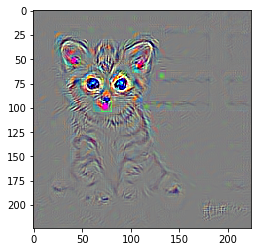

END


In [11]:
import torch
from torch import nn


class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            # 在全局变量中保存输入图片的梯度，该梯度由第一层卷积层
            # 反向传播得到，因此该函数需绑定第一个 Conv2d Layer
            self.image_reconstruction = grad_in[0]

        def forward_hook_fn(module, input, output):
            # 在全局变量中保存 ReLU 层的前向传播输出
            # 用于将来做 guided backpropagation
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            # ReLU 层反向传播时，用其正向传播的输出作为 guide
            # 反向传播和正向传播相反，先从后面传起
            grad = self.activation_maps.pop() 
            # ReLU 正向传播的输出要么大于0，要么等于0，
            # 大于 0 的部分，梯度为1，
            # 等于0的部分，梯度还是 0
            grad[grad > 0] = 1 
            
            # grad_out[0] 表示 feature 的梯度，只保留大于 0 的部分
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            # 创建新的输入端梯度
            new_grad_in = positive_grad_out * grad

            # ReLU 不含 parameter，输入端梯度是一个只有一个元素的 tuple
            return (new_grad_in,)


        # 获取 module，这里只针对 alexnet，如果是别的，则需修改
        modules = list(self.model.features.named_children())

        # 遍历所有 module，对 ReLU 注册 forward hook 和 backward hook
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # 对第1层卷积层注册 hook
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class):
        # 获取输出，之前注册的 forward hook 开始起作用
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
        
        # 生成目标类 one-hot 向量，作为反向传播的起点
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        # 反向传播，之前注册的 backward hook 开始起作用 
        model_output.backward(grad_target_map)
        # 得到 target class 对输入图片的梯度，转换成图片格式
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result.numpy()

def normalize(I):
    # 归一化梯度map，先归一化到 mean=0 std=1
    norm = (I-I.mean())/I.std()
    # 把 std 重置为 0.1，让梯度map中的数值尽可能接近 0
    norm = norm * 0.1
    # 均值加 0.5，保证大部分的梯度值为正
    norm = norm + 0.5
    # 把 0，1 以外的梯度值分别设置为 0 和 1
    norm = norm.clip(0, 1)
    return norm




if __name__=='__main__':
    from torchvision import models, transforms
    from PIL import Image
    import matplotlib.pyplot as plt

    image_path = './cat.png'
    I = Image.open(image_path).convert('RGB')
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    size = 224

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(I).unsqueeze(0).requires_grad_()

    model = models.alexnet(pretrained=True)

    guided_bp = Guided_backprop(model)
    result = guided_bp.visualize(tensor, None)

    result = normalize(result)
    plt.imshow(result)
    plt.show()


    print('END')